# Flow matching tutorial
*Séminaire au vert OBELIX 2025*

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import ot
from torchdiffeq import odeint_adjoint as odeint
import os
from scipy.stats import gaussian_kde
import datetime as dt
from pathlib import Path

import data_utils
import models

from importlib import reload # to be able to modify the modules and reload them without needing to restart the kernel.
def reload_all(): 
    reload(data_utils); reload(models)
reload_all()

from argparse import Namespace

device = "cuda" if torch.cuda.is_available() else "cpu"

2025-07-03 14:58:59.449634: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 14:58:59.470546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1/ General framework

The goal of flow matching is to transform a source distribution $p_0$ into the target distribution $p_1$. To do so, we consider a probability path $(p_t)_{t\in[0,1]}$ between $p_0$ and $p_1$. We also define a time-dependent flow $\Psi: [0,1] \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ that pushes $p_0$ to $p_t$: $p_t=[\Psi_t]*p_0$

The flow is defined with an Ordinary Differential Equation (ODE):
$\frac{d}{d t} \Psi_t(x) =v_t(\Psi_t(x))$

Marginal distribution:
$$p_t(x)=\int p_t\left(x \mid z\right) q\left(z\right) d z$$

Velocity field:
$$u_t(x)=\int u_t\left(x \mid z\right) \frac{p_t\left(x \mid z\right) q\left(z\right)}{p_t(x)} d z$$

**Question 1:** complete the `train_FM_model` method of the `FLOW_MATCHING` class, using the conditioning strategy of your choice.

**Question 2:** complete the `apply_flow_matching` method to compute the trajectories of points sampled in the latent distribution and ending (hopefully !) in the target distributions. You can consider the `odeint_adjoint` method of `torchdiffeq` package. 

In [ ]:
# Many parts of this code come from repository https://github.com/annegnx/PnP-Flow/
# illustrating paper 
# Martin, S., Gagneux, A., Hagemann, P. & Steidl, G. PnP-Flow: Plug-and-Play Image Restoration with Flow Matching. 2024.


class FLOW_MATCHING(object):

    def __init__(self, model, device, args, latent_sampler=None):
        """
        Args:
            model (nn.Module): model that computes the vector field for a given x (N, *data_shape) and a given t (N,).
            device (str): device on which to perform the training.
            args (Namespace): contains the different parameters.
            latent_sampler (function | None): function that samples the latent distribution. If None, a standard gaussian distribution is sampled.
        """
        self.data_shape = args.data_shape
        self.ndim = len(self.data_shape)

        self.device = device
        self.args = args
        self.lr = args.lr
        self.model = model.to(device)

        self.latent_sampler = latent_sampler
    
    def sample_latent(self, n_samples):
        """Sample points from the latent distribution (p_0). If none is given, the latent distribution
        is assumed to be a standard gaussian distribution.

        Args:
            n_samples (int): number of points to sample

        Returns:
            Tensor: Shape (n_samples, *self.data_shape), that is (n_samples, d) if data belongs to R^d, 
                (n_samples, C, W, H) if data belongs to R^{C x W x H}.
        """
        if self.latent_sampler is None:
            return torch.randn(n_samples, *self.data_shape, device=self.device)
        else:
            return self.latent_sampler(n_samples).float().to(self.device)

    def train_FM_model(self, train_loader, opt, num_epoch, scheduler=None):
        """Learn the flow-matching model on a given dataloader, with a given optimiser. More precisely, update the weights of self.model.

        Args:
            train_loader (DataLoader): DataLoader of the data to train on. Yields tuples (data_point, label) even if the label is not used.
            opt (optimiser): optimiser.
            num_epoch (int): number of epochs.
            scheduler (LRScheduler, optional): Learning-rate scheduler. Defaults to None.
        """
        
        self.loss_history = [] # You can store the loss of each epoch in this list.
        self.lr_history = []   # TODO: remove
        tq = tqdm(range(num_epoch))

        # if self.latent_sampler is not None:
        #     full_size = sum(len(batch) for batch, _ in train_loader)
        #     source_samples = self.sample_latent(full_size)
        #     source_dataset = TensorDataset(source_samples, torch.zeros(full_size))
        #     source_loader = DataLoader(source_dataset, batch_size=train_loader.batch_size, shuffle=True)
        # else:
        #     source_loader = None

        for ep in tq:

            epoch_loss = 0
            n_seen = 0

            # loaders = zip(train_loader, source_loader) if source_loader is not None else train_loader

            for iteration, (x, _) in enumerate(train_loader):
                # if source_loader is not None:
                #     (x, _), (z, _) = data
                #     x:torch.Tensor
                #     z:torch.Tensor
                #     x = x.to(self.device)
                #     z = z.to(self.device)
                # else:
                #     (x, _) = data

                x:torch.Tensor
                x = x.to(self.device)
                z = torch.randn(x.shape[0], *self.data_shape, device=self.device)

                t1 = torch.rand(x.shape[0], *((1,)*self.ndim), device=self.device)

                # compute coupling
                if self.args.coupling=="ot":
                    x0 = z.clone()
                    x1 = x.clone()
                    a, b = np.ones(len(x0)) / len(x0), np.ones(len(x0)) / len(x0)

                    M = ot.dist(x0.view(len(x0), -1).cpu().data.numpy(),
                                x1.view(len(x1), -1).cpu().data.numpy())
                    plan:np.ndarray = ot.emd(a, b, M)
                    p = plan.flatten()
                    p = p / p.sum()
                    choices = np.random.choice(
                        plan.shape[0] * plan.shape[1], p=p, size=len(x0), replace=True)
                    i, j = np.divmod(choices, plan.shape[1])
                    x0 = x0[i]
                    x1 = x1[j]
                elif self.args.coupling=="product":
                    x0 = z.clone()
                    x1 = x.clone()
                else:
                    raise ValueError(f"Coupling {self.args.coupling} not recognised.")
                    
                # plt.scatter(*x0.detach().cpu().T, s=10)
                # plt.scatter(*x1.detach().cpu().T, s=10)
                # plt.plot(*torch.stack([x0.T, x1.T], dim=1).detach().cpu(), c="k", zorder=0.9, lw=0.3)
                # return

                xt = t1 * x1 + (1 - t1) * x0
                
                loss = torch.sum(
                    (self.model(xt, t1.squeeze()) - (x1 - x0))**2
                ) / x.shape[0]
                
                opt.zero_grad()
                loss.backward()
                opt.step()

                epoch_loss += loss.item() * len(x)
                n_seen     += len(x)
            
            #TODO: remove scheduler
            if scheduler is not None:
                scheduler.step()
                lr_description = {"lr": f"{scheduler.get_last_lr()[0]:g}"}
                self.lr_history.append(scheduler.get_last_lr()[0])
            else:
                lr_description = {}

            epoch_loss /= n_seen
            tq.set_postfix(lr_description | {"loss": epoch_loss})
            self.loss_history.append(epoch_loss)
            

            # save samples, plot them, and compute FID on small dataset
            # if ep % 5 == 0:
            #     # evaluate FID
            #     fid_value = self.compute_fast_fid(2048)

    def apply_flow_matching(self, NO_samples, time_points):
        self.model.eval()
        with torch.no_grad():
            model_class = models.cnf(self.model) # convert the signature so that it is adapted to odeint
            latent = self.sample_latent(NO_samples)
            z_t = odeint(model_class, latent,
                         torch.tensor(time_points).to(self.device),
                         atol=1e-5,
                         rtol=1e-5,
                         method='dopri5',
                         )
        self.model.train()

        return z_t.detach()
    
    def save_model(self, folder="weights", name=None):
        if name is None:
            name = f"model_{dt.datetime.now().isoformat()}.pt"
        
        path = Path(folder) / name
        dico = {
            "model": self.model.state_dict(),
            "args": vars(self.args),
            "device": self.device,
        }
        torch.save(dico, path)
    
    def load_model(self, path):
        dico = torch.load(path)
        self.model.load_state_dict(dico["model"])

    # def compute_fast_fid(self, num_samples):
    #     block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    #     model = InceptionV3([block_idx]).to(self.device)
    #     data_v = next(iter(self.full_train_set))
    #     gt = data_v[0].to(self.device)[:num_samples]
    #     gt = gt.permute(0, 2, 3, 1).cpu().numpy()
    #     if gt.shape[-1] == 1:
    #         gt = np.concatenate([gt, gt, gt], axis=-1)
    #     gt = np.transpose(gt, axes=(0, 3, 1, 2))
    #     batch_size = 50
    #     m1, s1 = fs.calculate_activation_statistics(
    #         gt, model, batch_size, 2048, self.device)

    #     samples = torch.empty(0).to(self.device)
    #     n_iter = 50
    #     for i in range(n_iter):
    #         samples = torch.cat([samples.cpu(), self.apply_flow_matching(
    #             num_samples // n_iter).cpu()], dim=0)
    #     gen = torch.clip(samples.permute(0, 2, 3, 1), 0, 1).cpu().numpy()
    #     if gen.shape[-1] == 1:
    #         gen = np.concatenate([gen, gen, gen], axis=-1)
    #     gen = np.transpose(gen, axes=(0, 3, 1, 2))
    #     m2, s2 = fs.calculate_activation_statistics(
    #         gen, model, batch_size, 2048, self.device)
    #     fid_value = fs.calculate_frechet_distance(m1, s1, m2, s2)
    #     return fid_value

    def train(self, data_loaders):
        """Define the optimiser and train the flow matching model.

        Args:
            data_loaders (dict): dictionnary of dataloaders with an entry 'train'
        """

        # load data
        train_loader = data_loaders['train']

        # load full dataset on cpu to evaluate FID
        # full_data = DataLoaders(self.args.dataset, 2048, 2048)
        # self.full_train_set = full_data.load_data()['train']

        # define optimiser
        opt = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        scheduler_name = getattr(self.args, "scheduler", None)
        if scheduler_name is None:
            scheduler = None
        elif scheduler_name == "step":
            scheduler = torch.optim.lr_scheduler.StepLR(opt, self.args.scheduler_step_size, self.args.scheduler_gamma)
        else:
            raise ValueError(f"Scheduler {scheduler_name} not recognised")

        # start training
        self.train_FM_model(train_loader, opt, num_epoch=self.args.num_epoch, scheduler=scheduler)

## 1D distributions

**Question 3:** The first distribution we will try to sample is a 1D mixture of gaussians. The mixture is defined in data_utils, and you just have to call `data_utils.DataLoaders("gaussians", batch_size_train, batch_size_test)` to get your dataloader. Define a small model with the `models.ODEFunc` class (MLP with time dependancy), that will serve as vector field. Then train the flow matching on the mixture. 

In [3]:
args = Namespace(dataset="gaussians", num_epoch=1000, lr=1e-4, batch_size_train=128, batch_size_test=128, data_shape=(1,), coupling="ot", root=".")
data_loaders = data_utils.DataLoaders(args.dataset, args.batch_size_train, args.batch_size_test).load_data()
model = models.ODEFunc(dims=(1, 8, 8, 1))
model

ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [4]:
fm = FLOW_MATCHING(model, device=device, args=args)

In [5]:
fm.train(data_loaders)

100%|██████████| 1000/1000 [00:24<00:00, 41.33it/s, loss=0.174]


**Question 4:** Compute the trajectories of samples from the latent distribution and display them.

In [6]:
times = np.arange(0, 1, 0.01)
trajs = fm.apply_flow_matching(1000, times).cpu()[:, :, 0]

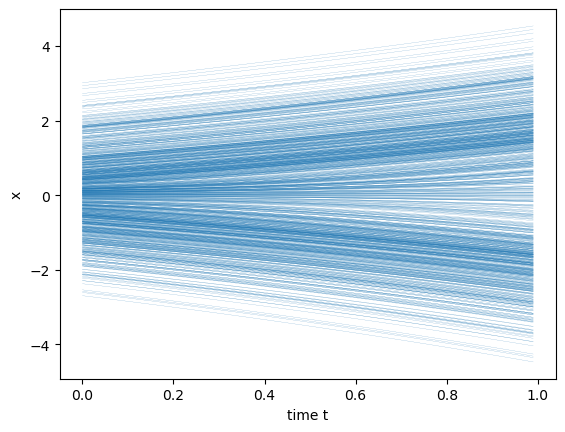

In [7]:
plt.plot(times, trajs, c="tab:blue", lw=0.1)
plt.ylabel("x")
plt.xlabel("time t")
plt.show()

Display the probability path, using kernel density estimation

In [8]:
x_discr = torch.linspace(-4, 4, 100)
probability_path = torch.zeros((len(times), len(x_discr)))
for i in range(len(times)):
    kernel = gaussian_kde(trajs[i])
    probability_path[i] = torch.from_numpy(kernel(x_discr))

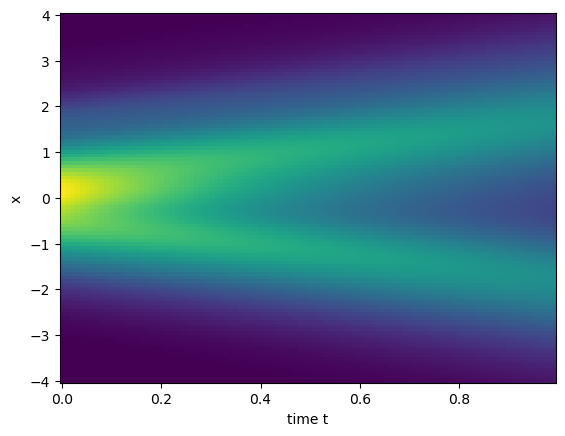

In [9]:
plt.pcolormesh(*np.meshgrid(times, x_discr.numpy()), probability_path.T)
plt.xlabel("time t")
plt.ylabel("x")
plt.show()

/tmp/ipykernel_18864/2689876081.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969118/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  plt.plot(x_discr, probability_path[i].T, c=plt.colormaps["viridis"](times[i]), label=f"t={times[i]:g}")


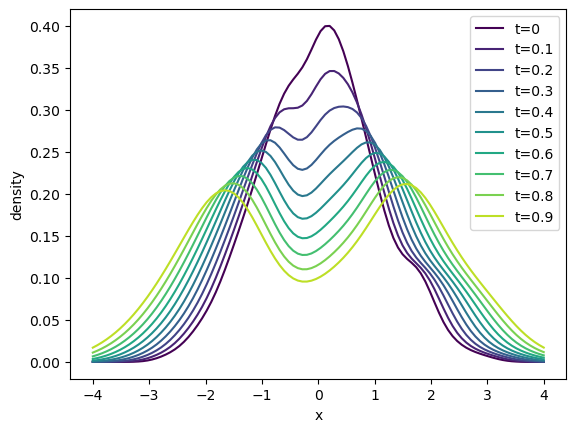

In [10]:
for i in range(0, len(times), 10):
    plt.plot(x_discr, probability_path[i].T, c=plt.colormaps["viridis"](times[i]), label=f"t={times[i]:g}")
plt.legend()
plt.xlabel("x")
plt.ylabel("density")
plt.show()

## 2D distributions

The second target distribution we will consider will be an Obélix distribution. To define such a distribution, we use the function `data_utils.load_image` (that loads the .jpg into an array) and the function `data_utils.cloud_transform` that compute a point cloud from it.

In Flow-Matching, we often sample from a gaussian latent distribution. But in practice, we can use any latent distribution ! We will consider the options here:
- in the first one, we will sample from a 2D standard gaussian distribution,
- in the second one, we will sample from an Astérix distribution.

### 0/ Display source and target distributions

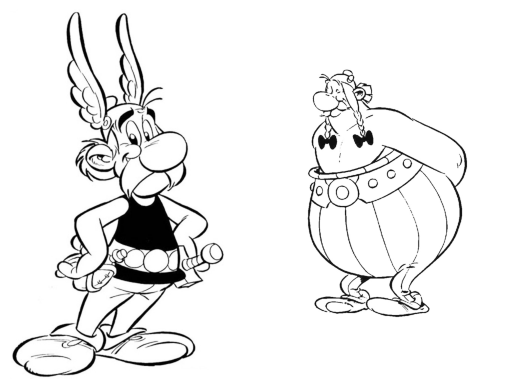

In [11]:
obelix = data_utils.load_image('obelix.jpg')
asterix = data_utils.load_image('asterix.jpg')
plt.subplot(121)
plt.imshow(asterix,cmap='Greys')
plt.axis('off')
plt.subplot(122)
plt.imshow(obelix,cmap='Greys')
plt.axis('off')
plt.show()

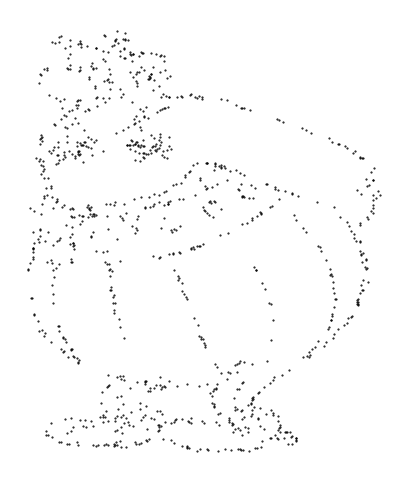

In [12]:
# Example of target distribution
cloud_obelix = data_utils.cloud_transform(obelix, n_samples=1000)
plt.figure(figsize=(5,6))
plt.scatter(cloud_obelix[:,0], cloud_obelix[:,1],marker='.',c='k',s=1)
plt.axis('off')
plt.show()

### 2/ Flow matching from gaussian

**Question 5:** train a flow matching model to sample an Obélix distribution. An Obélix data loader can be obtained by calling `data_utils.DataLoaders("obelix", ...)`. You may want to display samples obtained with your model, and trajectories latent -> obelix, using the `apply_flow_matching method`.

Don't have too high expectations on the final sampling you can get !

In [13]:
reload_all()
args2D = Namespace(dataset="obelix", num_epoch=2000, coupling="ot",
    lr=1e-2, scheduler=None, scheduler_step_size=1500, scheduler_gamma=0.1, 
    batch_size_train=200, batch_size_test=1000, data_shape=(2,))
data_loaders2D = data_utils.DataLoaders(args2D.dataset, args2D.batch_size_train, args2D.batch_size_test).load_data()
model2D = models.ODEFunc(dims=(2, 16, 16, 12, 8, 2), bn=True)
model2D

ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=16, out_features=12, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=12, out_features=8, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=8, out_features=2, bias=True)
  )
)

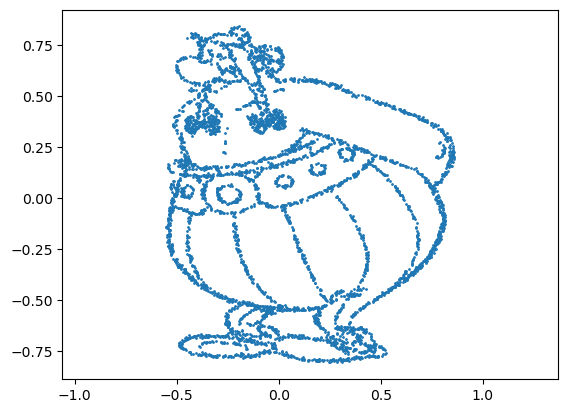

In [14]:
# Check dataloader
obelix_points = torch.cat([batch for batch, _ in data_loaders2D["train"]])
plt.scatter(*obelix_points.T, s=1)
plt.axis("equal")
plt.show()

In [15]:
fm2D = FLOW_MATCHING(model2D, device="cuda", args=args2D)

In [16]:
fm2D.train(data_loaders2D)

100%|██████████| 2000/2000 [04:37<00:00,  7.20it/s, loss=0.0616]


In [ ]:
# fm2D.save_model()

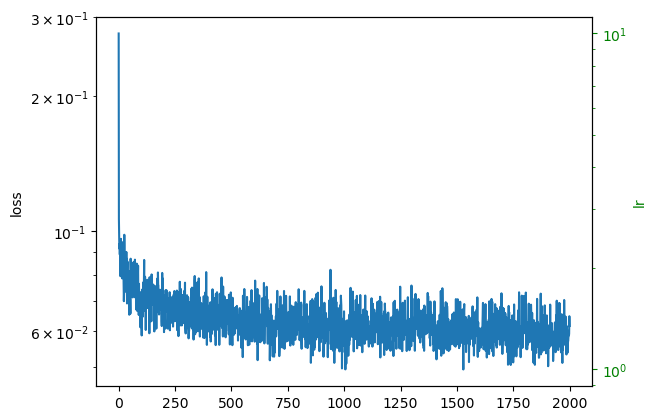

In [17]:
plt.semilogy(fm2D.loss_history)
plt.ylabel("loss")

twin = plt.gca().twinx()
plt.semilogy(fm2D.lr_history, "g", lw=0.2)
plt.ylabel("lr", color="g")
plt.tick_params(axis="y", which="both", color="g", labelcolor="g")
# plt.grid("y")

plt.xlabel("epoch")
plt.show()

Compute the trajectories of new samples to sample new points from the target distribution

In [18]:
traj2D = fm2D.apply_flow_matching(5000, np.arange(0, 1, 0.01)).cpu()

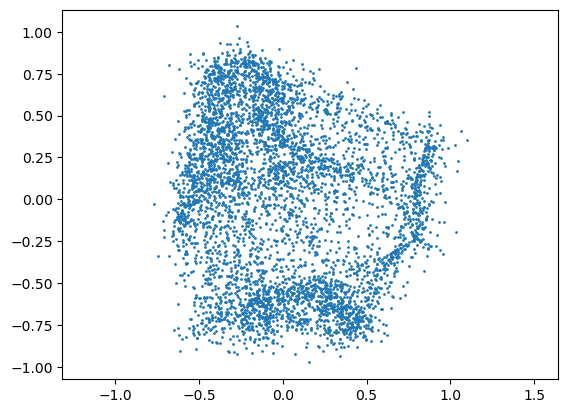

In [19]:
# plt.scatter(*obelix_points.T, s=10)
plt.scatter(*traj2D[-1].T, s=1)
plt.axis("equal")
plt.show()

Show some of the trajectories

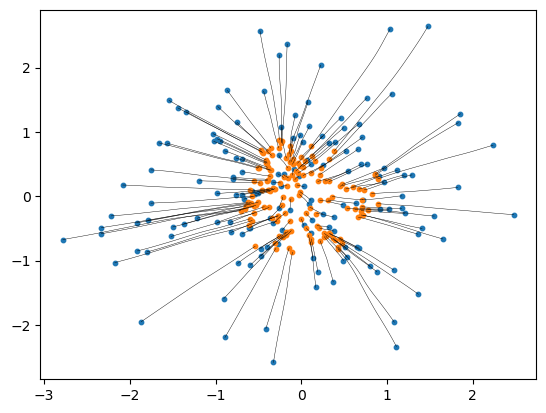

In [20]:
num_points = 150
plt.scatter(traj2D[ 0, :num_points, 0], traj2D[ 0, :num_points, 1], s=10)
plt.scatter(traj2D[-1, :num_points, 0], traj2D[-1, :num_points, 1], s=10)
plt.plot(traj2D[:, :num_points, 0], traj2D[:, :num_points, 1], "k", lw=0.3)
plt.show()

### 3/ Flow matching from data distribution

**Question 6:** Do the same but with an Astérix latent distribution ! You can use the latent_sampler argument of the FLOW_MATCHING class.

In [77]:
reload_all()
args_ast = Namespace(dataset="obelix", num_epoch=2000, coupling="ot",
    lr=1e-2, scheduler=None, scheduler_step_size=1500, scheduler_gamma=0.1, 
    batch_size_train=2000, batch_size_test=1000, data_shape=(2,))
data_loaders_ast = data_utils.DataLoaders(args_ast.dataset, args_ast.batch_size_train, args_ast.batch_size_test).load_data()
model_ast = models.ODEFunc(dims=(2, 16, 16, 12, 8, 2), bn=True)
model_ast

ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=16, out_features=12, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=12, out_features=8, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=8, out_features=2, bias=True)
  )
)

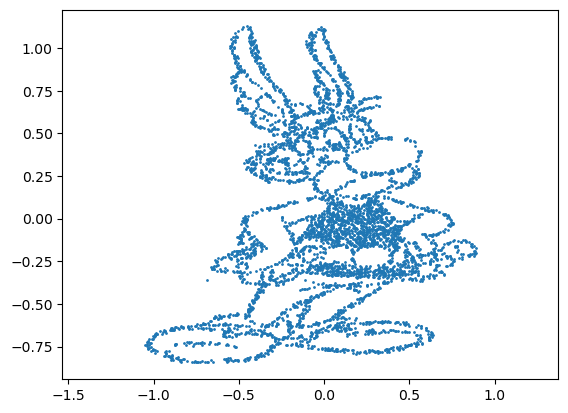

In [78]:
def asterix_sampler(n_samples):
    return torch.tensor(data_utils.cloud_transform(asterix, n_samples))
# asterix_loader = data_utils.DataLoaders("asterix", 5000, args2D.batch_size_test).load_data()["train"]
# def asterix_sampler(n_sample):
#     return next(asterix_loader)
# plt.scatter(*torch.cat([batch for batch, _ in asterix_loader]).T, s=1)

plt.scatter(*asterix_sampler(5000).T, s=1)
plt.axis("equal")
plt.show()

In [79]:
fm_ast = FLOW_MATCHING(model_ast, device="cuda", args=args_ast, latent_sampler=asterix_sampler)

In [80]:
fm_ast.train(data_loaders_ast)

  1%|          | 21/2000 [00:19<30:08,  1.09it/s, loss=0.0072] 


KeyboardInterrupt: 

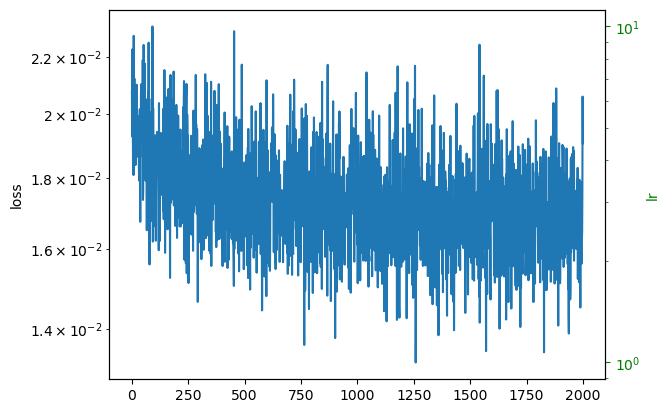

In [169]:
plt.semilogy(fm_ast.loss_history)
plt.ylabel("loss")

twin = plt.gca().twinx()
plt.semilogy(fm_ast.lr_history, "g", lw=0.2)
plt.ylabel("lr", color="g")
plt.tick_params(axis="y", which="both", color="g", labelcolor="g")
# plt.grid("y")

plt.xlabel("epoch")
plt.show()

In [173]:
osk = fm_ast.__dict__
fm_ast = FLOW_MATCHING(model2D, device="cuda", args=args2D)
fm_ast.__dict__ = osk

Compute the trajectories of new samples to sample new points from the target distribution

In [184]:
traj_ast = fm_ast.apply_flow_matching(1000, np.arange(0, 1, 0.01), source_loader=asterix_loader).cpu()

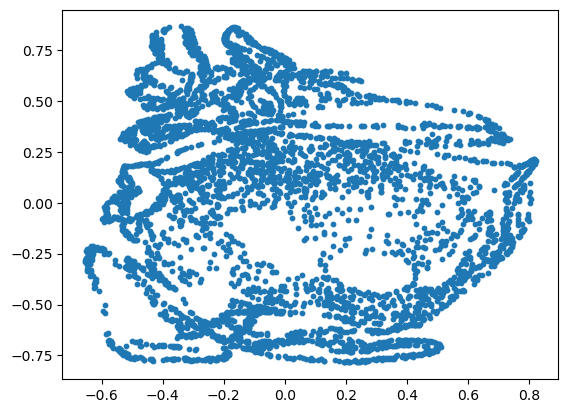

In [185]:
# plt.scatter(*obelix_points.T, s=10)
plt.scatter(*traj_ast[-1].T, s=10)
plt.show()

Show some of the trajectories

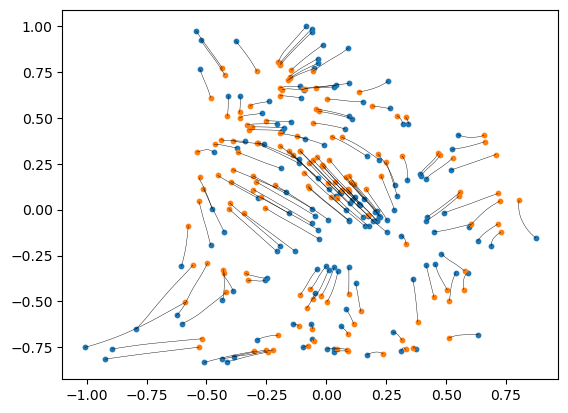

In [186]:
num_points = 150
plt.scatter(traj_ast[ 0, :num_points, 0], traj_ast[ 0, :num_points, 1], s=10)
plt.scatter(traj_ast[-1, :num_points, 0], traj_ast[-1, :num_points, 1], s=10)
plt.plot(traj_ast[:, :num_points, 0], traj_ast[:, :num_points, 1], "k", lw=0.3)
plt.show()

## "Real" data

### MNIST images generation

### Conditional generative modelling